## Recommendations tutorial

In this tutorial we will learn and compare two basic recommendation algorithms:
1. [FunkSvd](https://medium.com/datadriveninvestor/how-funk-singular-value-decomposition-algorithm-work-in-recommendation-engines-36f2fbf62cac)
2. [Neural Collaborative Filtering](https://arxiv.org/abs/1708.05031)

This is a minimal demo adapted from https://github.com/guoyang9/NCF

In [1]:
%matplotlib inline

In [2]:
import time
import os
import requests
import tqdm

import numpy as np
import pandas as pd
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td
import torch.optim as to

import matplotlib.pyplot as pl
import seaborn as sns

In [3]:
# Configuration

# The directory to store the data
data_dir = "data"

train_rating = "ml-1m.train.rating"
test_negative = "ml-1m.test.negative"

# NCF config
train_negative_samples = 4
test_negative_samples = 99
embedding_dim = 64
hidden_dim = 32

# Training config
batch_size = 256
epochs = 10  # Original implementation uses 20
top_k=10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download and preprocess the data

Use Movielens 1M data from the NCF paper authors' implementation https://github.com/hexiangnan/neural_collaborative_filtering

In [4]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
for file_name in [train_rating, test_negative]:
    file_path = os.path.join(data_dir, file_name)
    if os.path.exists(file_path):
        print("Skip loading " + file_name)
        continue
    with open(file_path, "wb") as tf:
        print("Load " + file_name)
        r = requests.get("https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/" + file_name, allow_redirects=True)
        tf.write(r.content)

Skip loading ml-1m.train.rating
Skip loading ml-1m.test.negative


In [5]:
def preprocess_train():
    train_data = pd.read_csv(os.path.join(data_dir, train_rating), sep='\t', header=None, names=['user', 'item'], usecols=[0, 1], dtype={0: np.int32, 1: np.int32})

    user_num = train_data['user'].max() + 1
    item_num = train_data['item'].max() + 1

    train_data = train_data.values.tolist()

    # Convert ratings as a dok matrix
    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for user, item in train_data:
        train_mat[user, item] = 1.0
        
    return train_data, train_mat, user_num, item_num


train_data, train_mat, user_num, item_num = preprocess_train()

In [6]:
def preprocess_test():
    test_data = []
    with open(os.path.join(data_dir, test_negative)) as tnf:
        for line in tnf:
            parts = line.split('\t')
            assert len(parts) == test_negative_samples + 1
            
            user, positive = eval(parts[0])
            test_data.append([user, positive])
            
            for negative in parts[1:]:
                test_data.append([user, int(negative)])

    return test_data


test_data = preprocess_test()

### Pytorch dataset

In [7]:
class NCFDataset(td.Dataset):
    
    def __init__(self, positive_data, item_num, positive_mat, negative_samples=0):
        super(NCFDataset, self).__init__()
        self.positive_data = positive_data
        self.item_num = item_num
        self.positive_mat = positive_mat
        self.negative_samples = negative_samples
        
        self.reset()
        
    def reset(self):
        print("Resetting dataset")
        if self.negative_samples > 0:
            negative_data = self.sample_negatives()
            data = self.positive_data + negative_data
            labels = [1] * len(self.positive_data) + [0] * len(negative_data)
        else:
            data = self.positive_data
            labels = [0] * len(self.positive_data)
            
        self.data = np.concatenate([np.array(data), np.array(labels)[:, np.newaxis]], axis=1)
        

    def sample_negatives(self):
        negative_data = []
        for user, positive in self.positive_data:
            for _ in range(self.negative_samples):
                negative = np.random.randint(self.item_num)
                while (user, negative) in self.positive_mat:
                    negative = np.random.randint(self.item_num)
                    
                negative_data.append([user, negative])

        return negative_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, item, label = self.data[idx]
        return user, item, label

### Implement recommendation models in Pytorch

Because this is what people do in 2020

In [8]:
class Ncf(nn.Module):
    
    def __init__(self, user_num, item_num, embedding_dim, hidden_dim):
        super(Ncf, self).__init__()
        
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num, embedding_dim)

        self.layers = nn.Sequential(
            nn.Linear(2 * embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        self.initialize()

    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)

        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                layer.bias.data.zero_()
            
    def forward(self, user, item):
        user_embedding = self.user_embeddings(user)
        item_embedding = self.item_embeddings(item)
        concat = torch.cat((user_embedding, item_embedding), -1)
        return self.layers(concat).view(-1)
    
    def name(self):
        return "Ncf"

In [9]:
class FunkSvd(nn.Module):
    
    def __init__(self, user_num, item_num, embedding_dim):
        super(FunkSvd, self).__init__()
        
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num, embedding_dim)
        
        self.user_bias = nn.Embedding(user_num, 1)
        self.item_bias = nn.Embedding(item_num, 1)
        
        self.bias = torch.nn.Parameter(torch.tensor(0.0))

        self.initialize()

    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        nn.init.normal_(self.user_bias.weight, std=0.01)
        nn.init.normal_(self.item_bias.weight, std=0.01)
            
    def forward(self, user, item):
        user_embedding = self.user_embeddings(user)
        user_bias = self.user_bias(user).view(-1)
        item_embedding = self.item_embeddings(item)
        item_bias = self.item_bias(item).view(-1)
        dot = (user_embedding * item_embedding).sum(1)
        return dot + user_bias + item_bias + self.bias
    
    def name(self):
        return "FunkSvd"

### Metrics

- mean hit rate @K 
- mean DCG @K

Test data is organized as a sequence `user -> [positive_item, negative_item_1, ..., negative_item_99]`. Each batch in the test loader contains the data for a single user in the same order.

In [10]:
def hit_metric(actual, recommended):
    return int(actual in recommended)


def dcg_metric(actual, recommended):
    if actual in recommended:
        index = recommended.index(actual)
        return np.reciprocal(np.log2(index + 2))
    return 0


def metrics(model, test_loader, top_k):
    hits, dcgs = [], []

    for user, item, label in test_loader:
        item = item.to(device)
        
        predictions = model(user.to(device), item)
        _, indices = torch.topk(predictions, top_k)
        recommended = torch.take(item, indices).cpu().numpy().tolist()

        item = item[0].item()
        hits.append(hit_metric(item, recommended))
        dcgs.append(dcg_metric(item, recommended))

    return np.mean(hits), np.mean(dcgs)

### Basic training loop

Notes 
 - resample new negatives at each epoch
 - no early stopping, checkpointing, LR decay etc.; this is a demo, remember?

In [11]:
def train(model):
    train_dataset = NCFDataset(train_data, item_num, train_mat, train_negative_samples)
    train_loader = td.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    test_dataset = NCFDataset(test_data, item_num, train_mat)
    test_loader = td.DataLoader(test_dataset, batch_size=test_negative_samples+1, shuffle=False, num_workers=0)
    
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = to.Adam(model.parameters())

    history = []
    for epoch in range(epochs):
        model.train()
        
        train_loader.dataset.reset()

        start_time = time.time()
        for user, item, label in tqdm.tqdm(train_loader):
            model.zero_grad()
            prediction = model(user.to(device), item.to(device))
            loss = loss_function(prediction, label.to(device).float())
            loss.backward()
            optimizer.step()

        model.eval()
        hr, dcg = metrics(model, test_loader, top_k)
        elapsed = time.time() - start_time
        history.append({"model": model.name(), "epoch": epoch, "hit_rate": hr, "dcg": dcg, "elapsed": elapsed})

        print("[{model}] epoch: {epoch}, hit rate: {hit_rate}, dcg: {dcg}".format(**history[-1]))
    
    return history

### Experiment

It takes a couple of minutes per epoch on GTX 1080

In [ ]:
print("# Train NCF")
ncf = Ncf(user_num, item_num, embedding_dim, hidden_dim).to(device)
ncf_history = train(ncf)

print("# Train FunkSVD")
svd = FunkSvd(user_num, item_num, embedding_dim).to(device)
svd_history = train(svd)

In [13]:
history = pd.DataFrame(ncf_history + svd_history)

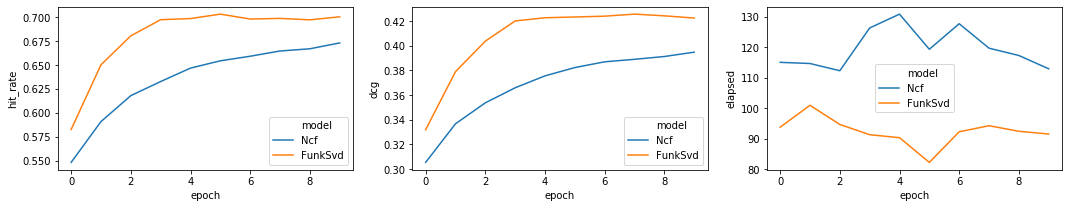

In [14]:
columns = ["hit_rate", "dcg", "elapsed"]

figure, axes = pl.subplots(nrows=1, ncols=3, sharex=True, figsize=(18, 3))

for j, column in enumerate(columns):
    sns.lineplot(x="epoch", y=column, hue="model", data=history, ax=axes[j])